# Git workflow for MARBL

Given the scientific nature of the MARBL library, it is not practical to expect users to update to the latest version of the library regularly. This workflow is designed to allow bugfixes to be applied to old releases. There are two main branches: _development_ contains the latest development code, and _stable_ is the latest release.

**REQUIREMENT:** _development_ must be even with our directly ahead of _stable_; a new release will be made by _git checkout stable ; git merge development --ff-only_

When a GCM incorporates a specific version of MARBL, we will make a GCM-specific release branch off of _stable_. Example: the _v0.29.0_ on _development_ will correspond to the _v1.0.0-beta01_ tag on _stable_. This is the version of MARBL to be used in CESM 2.0, so we will also make a _cesm2.0_ branch (and a _cesm2.0-n00_ tag) at this point.

In [1]:
import pydot

all_nodes = dict()
def new_node(graph, node_label, node_color, branch="other", label=""):
    if branch in ['development', 'stable', 'release']:
        shape = "octagon"
    else:
        shape = "circle"
    node_id = branch+"."+node_label
    if label != "":
        # To color label, use HTML
        # from https://stackoverflow.com/questions/16265541/pygraphviz-xlabel-position-and-color-doesnt-work
        xlabel = '<<TABLE BORDER="0" CELLBORDER="0" CELLSPACING="0"><TR><TD><FONT COLOR="' + \
                 colors[branch] + '">' +label + \
                 '</FONT></TD></TR></TABLE>>'
    else:
        xlabel = ""
    all_nodes[node_id] = pydot.Node(node_id, label=node_label, color=colors[branch], fontcolor="black",
                                    style="filled", fillcolor=node_color, shape=shape,
                                    penwidth=3, xlabel=xlabel, xcolor=colors[branch])
    graph.add_node(all_nodes[node_id])

def new_edge(graph, node1, node2, label, color):
    edge = pydot.Edge(node1, node2, penwidth=3, label=label, color=color) # edge for development
    graph.add_edge(edge)

def same_nodes(graph, branches, commit):
    subgraph = pydot.Subgraph(rank='same')
    for prefix in branches:
        subgraph.add_node(all_nodes[prefix+"."+commit])
    graph.add_subgraph(subgraph)

# Function to render pydot graph -- I believe this requires the graphviz package
# from https://stackoverflow.com/a/36463158
from IPython.display import Image, display
def viewPydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

# Color choices and label names
colors = {"development": "black", "stable": "blue", "release": "green", "other": "gray"}
labels = {"development": "dev", "stable": "sta"}
new_node_color = "#DDDDDD"

# What do the colors mean?
print("How to read this chart\n----")
print("* The charts are color-coordinated:")
print("  - %s indicates work on the development branch" % colors["development"])
print("  - %s indicates work on the stable branch" % colors["stable"])
print("  - %s indicates work on a release branch (one per release that needs on-going support)" % colors["release"])
print("  - %s indicates active development work (typically a branch in a fork of repository)" % colors["other"])
print("* Nodes represent individual commits, and they are numbered chronologically.")
print("  - Octagons indicate a commit with a tag");
print("  - Circles represent a commit without a tag")
print("  - Tag name is in exterior label")
print("* Edges trace the history of different branches (and are labelled with the branch name.)")
print("* The same commit can be in the history of multiple branches")
print("  - Nodes with the same interior label are the same sha")
print("  - These nodes will always fall on the same horizontal line")

How to read this chart
----
* The charts are color-coordinated:
  - black indicates work on the development branch
  - blue indicates work on the stable branch
  - green indicates work on a release branch (one per release that needs on-going support)
  - gray indicates active development work (typically a branch in a fork of repository)
* Nodes represent individual commits, and they are numbered chronologically.
  - Octagons indicate a commit with a tag
  - Circles represent a commit without a tag
  - Tag name is in exterior label
* Edges trace the history of different branches (and are labelled with the branch name.)
* The same commit can be in the history of multiple branches
  - Nodes with the same interior label are the same sha
  - These nodes will always fall on the same horizontal line


## Initial State

To start, we'll think of commit `C0` as our starting point for testing for the CESM 2.0 release. This commit exists on three branchs (with the same sha): _cesm2.0_, _stable_, and _development_; it is tagged as _cesm2.0-n00_, _cesm1.0.0-beta01_, and _v0.29.0_.


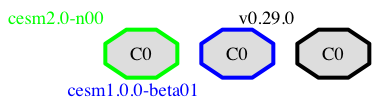

In [2]:
def initial_release(title="", node_color="white"):
    # initialize graph
    graph = pydot.Dot(graph_type='digraph', label=title, fontsize=20)

    # Add nodes for starting point of development, stable, and cesm2.0 branches
    new_node(graph, "C0", node_color, branch="release", label="cesm2.0-n00")
    new_node(graph, "C0", node_color, branch="stable", label="cesm1.0.0-beta01")
    new_node(graph, "C0", node_color, branch="development", label="v0.29.0")

    # Force all three nodes to be even with each other
    same_nodes(graph, ['release', 'stable', 'development'], 'C0')

    return graph

# Draw graph
viewPydot(initial_release(node_color=new_node_color))


## Bug found in CESM testing

In the CESM testing, we find an issue. A new _bugfix_ branch is made from the _cesm2.0_ branch, the issue is resolved in `C1`, and then the bugfix is merged back to _cesm2.0_ with `git merge bugfix --no-ff`, resulting in `C2`. Also, _cesm2.0_ is merged onto _stable_ and _development_ with `git merge cesm2.0 --ff-only`. `C2` is tagged as _cesm2.0-n01_, _cesm1.0.0-beta02_, and _v0.29.1_.

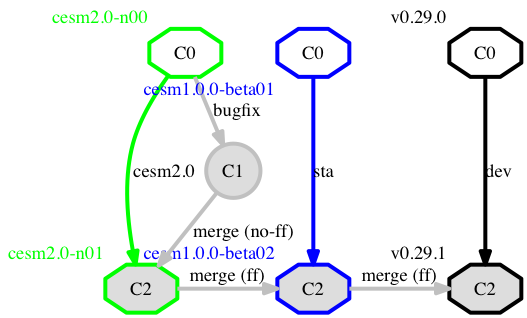

In [3]:
def stage1(title="", node_color="white"):
    # Initialize graph
    graph = initial_release()

    # Add node for new release
    new_node(graph, "C2", node_color, branch="release", label="cesm2.0-n01")
    new_node(graph, "C2", node_color, branch="stable", label="cesm1.0.0-beta02")
    new_node(graph, "C2", node_color, branch="development", label="v0.29.1")

    # Force all three nodes to be even with each other
    same_nodes(graph, ['release', 'stable', 'development'], 'C2')

    # Add new node for bugfix
    new_node(graph, "C1", node_color)
    
    # Edges for cesm2.0 release branch, as well as development and stable
    labels["release"] = "cesm2.0"
    for prefix in ['release', 'stable', 'development']:
        new_edge(graph, prefix+".C0", prefix+".C2", labels[prefix], colors[prefix])
    
    # Edges for bugfix and merges
    new_edge(graph, "release.C0", "other.C1", "bugfix", colors["other"])
    new_edge(graph, "other.C1", "release.C2", "merge (no-ff)", colors["other"])
    new_edge(graph, "release.C2", "stable.C2", "merge (ff)", colors["other"])
    new_edge(graph, "stable.C2", "development.C2", "merge (ff)", colors["other"])
    
    return graph

# Draw graph
viewPydot(stage1(node_color=new_node_color))

## Working towards CESM 2.1

Now suppose we are ready to develop something new for CESM 2.1. We create a new branch _enhancement_ from _development_, and make commits `C3` and `C4` on it, and then merge it back to _development_ with `git merge enhancement --no-ff`, resulting in `C5`. Also, _development_ is merged onto _stable_ with `git merge development --ff-only`, and we create a new branch _cesm2.1_ from this commit. `C5` is tagged as _v0.30.0_, _cesm1.0.0-beta03_, and _cesm2.1-n00_.


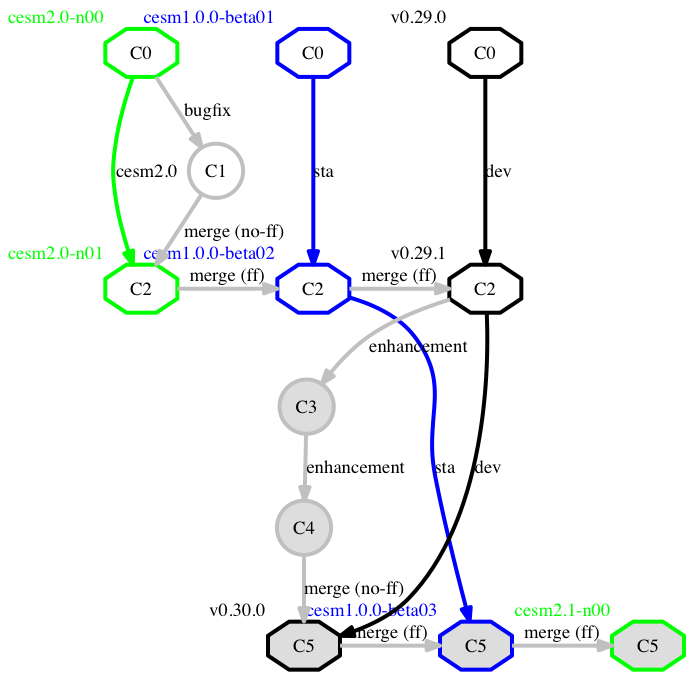

In [4]:
def stage2(title="", node_color="white"):
    graph = stage1(title)

    # Add node for new release
    new_node(graph, "C5", node_color, branch="release", label="cesm2.1-n00")
    new_node(graph, "C5", node_color, branch="stable", label="cesm1.0.0-beta03")
    new_node(graph, "C5", node_color, branch="development", label="v0.30.0")

    # Force all three nodes to be even with each other
    same_nodes(graph, ['development', 'stable', 'release'], 'C5')

    # Add nodes for enhancement
    new_node(graph, "C3", node_color)
    new_node(graph, "C4", node_color)

    # Edges for development and stable
    for prefix in ['stable', 'development']:
        new_edge(graph, prefix+".C2", prefix+".C5", labels[prefix], colors[prefix])

    # Edges for enhancement and merge
    new_edge(graph, "development.C2", "other.C3", "enhancement", colors["other"])
    new_edge(graph, "other.C3", "other.C4", "enhancement", colors["other"])
    new_edge(graph, "other.C4", "development.C5", "merge (no-ff)", colors["other"])
    new_edge(graph, "development.C5", "stable.C5", "merge (ff)", colors["other"])
    new_edge(graph, "stable.C5", "release.C5", "merge (ff)", colors["other"])

    
    return graph

# Draw graph
viewPydot(stage2(node_color=new_node_color))

# Oh no, another bug on cesm2.0 release branch!

At this point, we realize there is a bug in `C2` that we want to fix for _cesm2.0_. So we make the _bugfix2_ branch off of `C2`, make commits `C6` and `C7` to fix the bug, and then merge it back to _cesm2.0_ with `git merge bugfix2 --no-ff`, resulting in `C8`. That commit is tagged _cesm2.0-n02_

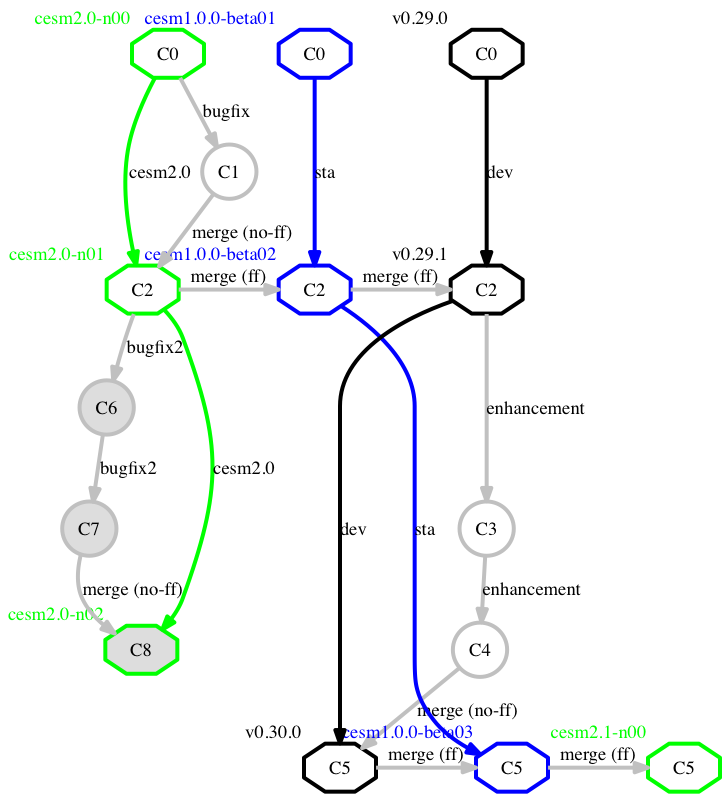

In [5]:
def stage3(title="", node_color="white"):
    graph = stage2(title)

    # Add node for new cesm2.0 release
    new_node(graph, "C8", node_color, branch="release", label="cesm2.0-n02")
    
    # Add nodes for bugfix2
    new_node(graph, "C6", node_color)
    new_node(graph, "C7", node_color)

    # Merged node even with "C3"
    subgraph1 = pydot.Subgraph(rank='same')
    subgraph1.add_node(all_nodes["other.C3"])
    subgraph1.add_node(all_nodes["other.C7"])
    graph.add_subgraph(subgraph1)

    # Release node even with "C4"
    subgraph1 = pydot.Subgraph(rank='same')
    subgraph1.add_node(all_nodes["other.C4"])
    subgraph1.add_node(all_nodes["release.C8"])
    graph.add_subgraph(subgraph1)

    # Edge for cesm2.0
    new_edge(graph, "release.C2", "release.C8", "cesm2.0", colors["release"])

    # Edges for bugfix and merge to dev
    new_edge(graph, "release.C2", "other.C6", "bugfix2", colors["other"])
    new_edge(graph, "other.C6", "other.C7", "bugfix2", colors["other"])
    new_edge(graph, "other.C7", "release.C8", "merge (no-ff)", colors["other"])

    return graph

# Draw graph
viewPydot(stage3(node_color=new_node_color))

### Merging bugfix back to development, stable, and cesm2.1

Now that the bug has been fixed in the oldest release, we merge `C8` back to `development` with `git merge cesm2.0 --no-ff`, resulting in `C9`. Also, _development_ is merged onto _stable_ and _cesm2.1_ with `git merge development --ff-only`, and that commit is labeled _v0.30.1_, _v1.0.0-beta04_, and _cesm2.1-n02_.

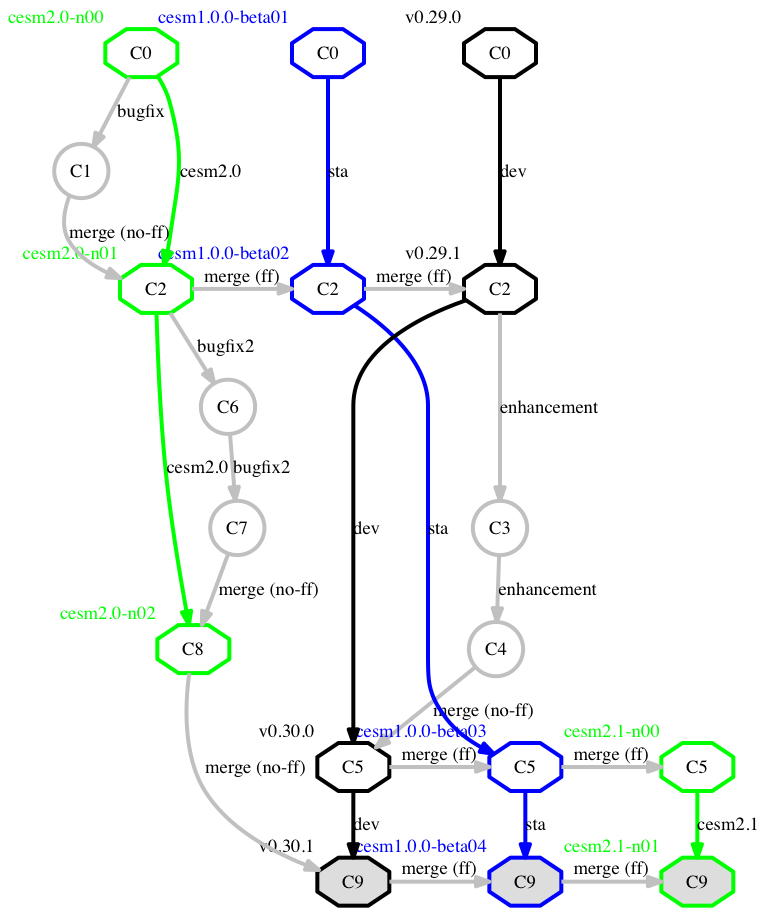

In [6]:
def stage4(title="", node_color="white"):
    graph = stage3(title)

    # Add node for new release
    new_node(graph, "C9", node_color, branch="release", label="cesm2.1-n01")
    new_node(graph, "C9", node_color, branch="stable", label="cesm1.0.0-beta04")
    new_node(graph, "C9", node_color, branch="development", label="v0.30.1")

    # Force all three nodes to be even with each other
    same_nodes(graph, ['development', 'stable', 'release'], 'C9')
    #new_node(graph, "C9", stable["color"], node_color, label="v0.30.1\lv1.0.0-beta04\lcesm2.1-n01\l", shape="tripleoctagon")

    # Edges for cesm2.1 release branch, as well as development and stable
    labels["release"] = "cesm2.1"
    for prefix in ['release', 'stable', 'development']:
        new_edge(graph, prefix+".C5", prefix+".C9", labels[prefix], colors[prefix])

    # Edges for merge from cesm2.0 release to development
    new_edge(graph, "release.C8", "development.C9", "merge (no-ff)", colors["other"])

    # ff merge to stable and cesm2.1 release
    new_edge(graph, "development.C9", "stable.C9", "merge (ff)", colors["other"])
    new_edge(graph, "stable.C9", "release.C9", "merge (ff)", colors["other"])    
    return graph

# Draw graph
viewPydot(stage4(node_color=new_node_color))

## Enhancement that leads to v1.0.0

Now we are ready to develop something new for MARBL v1.0.0, we just want to add two new features.

### First feature

We create a new branch _feature_ off of `development`, and make commits `C10`, `C11`, and `C12` on it, and then merge it back to _development_ with `git merge enhancement --no-ff`, resulting in `C13`. This is tagged `v1.0-beta0.1`.

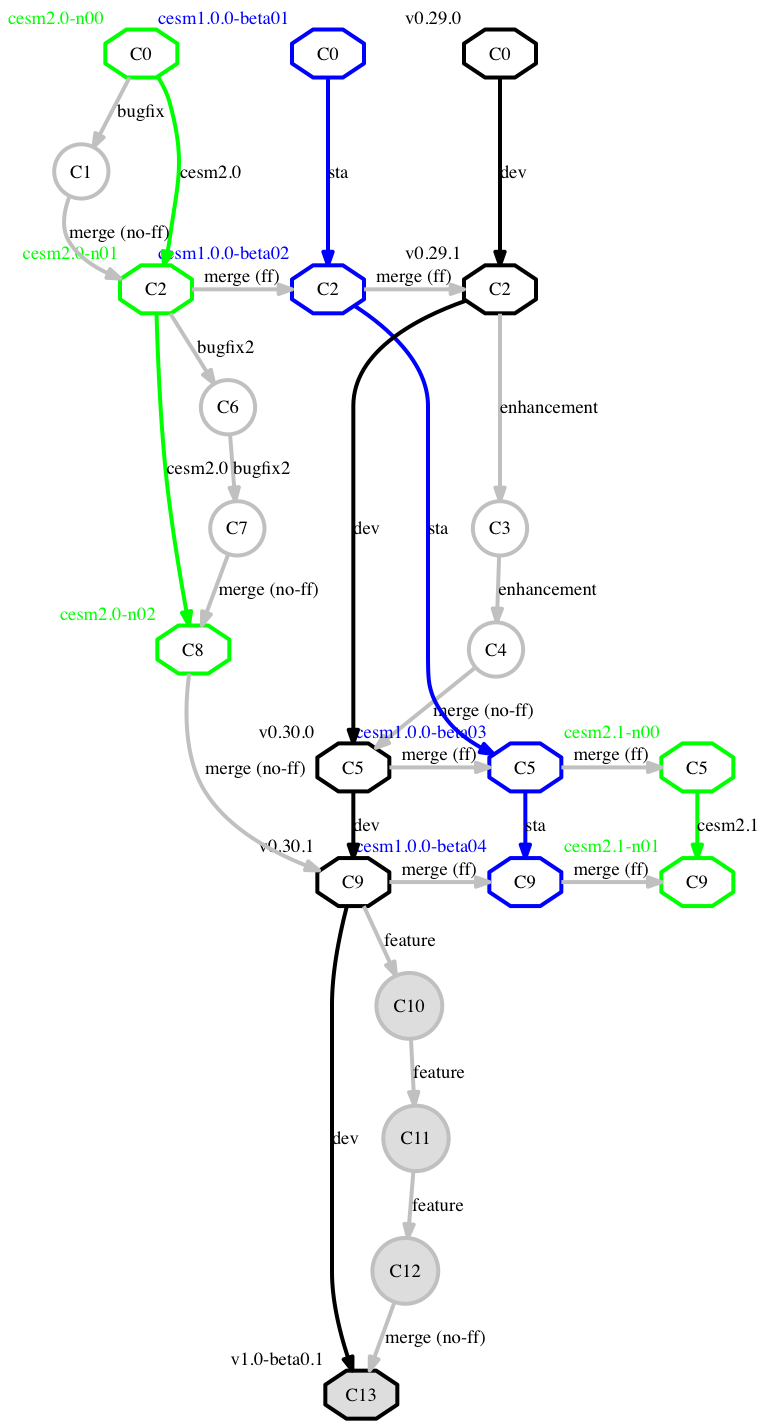

In [7]:
def stage5(title="", node_color="white"):
    graph = stage4(title)

    # Add node for new development
    new_node(graph, "C13", node_color, branch="development", label="v1.0-beta0.1")

    # Add nodes for feature
    new_node(graph, "C10", node_color)
    new_node(graph, "C11", node_color)
    new_node(graph, "C12", node_color)

    # Edges for feature and merge
    new_edge(graph, "development.C9", "other.C10", "feature", colors["other"])
    new_edge(graph, "other.C10", "other.C11", "feature", colors["other"])
    new_edge(graph, "other.C11", "other.C12", "feature", colors["other"])
    new_edge(graph, "other.C12", "development.C13", "merge (no-ff)", colors["other"])

    # Edge for development
    new_edge(graph, "development.C9", "development.C13", labels["development"], colors["development"])

    return graph

# Draw graph
viewPydot(stage5(node_color=new_node_color))

### Second feature

Next we create a new branch _feature2_ off of `development`, and make commits `C14` and `C15` on it, and then merge it back to _development_ with `git merge enhancement --no-ff`, resulting in `C16`. This is tagged `v1.0-beta0.2`.

Assuming we are happy with pre-release testing, _development_ is merged onto _stable_ with `git merge development --ff-only` and `C16` also gets tagged `v1.0.0`.

**NOTE:** `C13` is in the direct (`--first-parent`) history of _stable_ but there was never a time that it was the `HEAD` of stable.

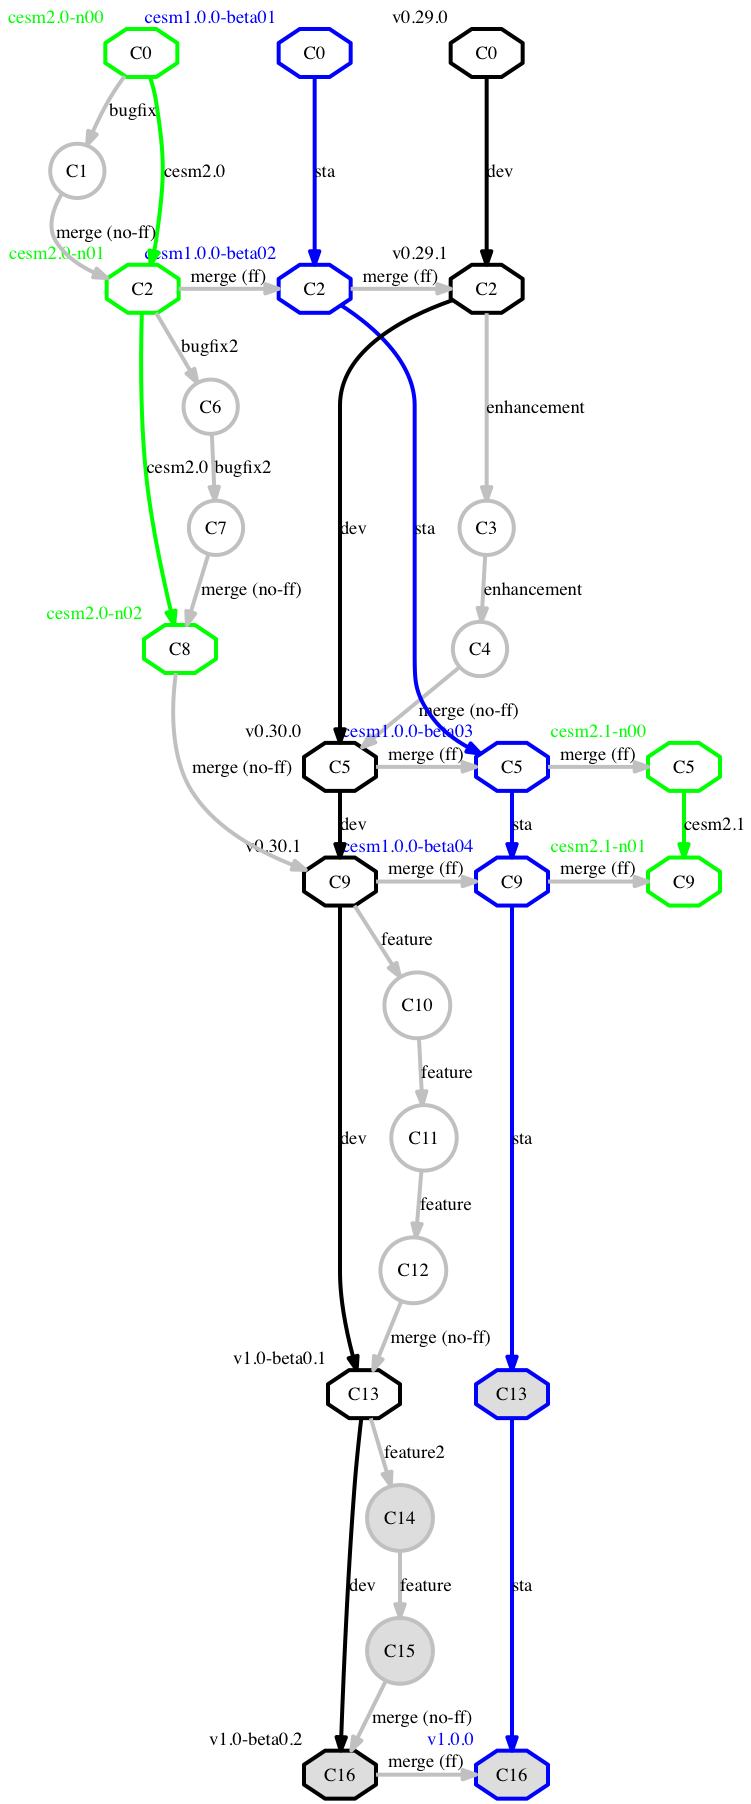

In [8]:
def stage6(title="", node_color="white"):
    graph = stage5(title)

    # Add node for new release
    new_node(graph, "C13", node_color, branch="stable")
    new_node(graph, "C16", node_color, branch="development", label="v1.0-beta0.2")
    new_node(graph, "C16", node_color, branch="stable", label="v1.0.0")

    # Force nodes to be even with each other
    same_nodes(graph, ['development', 'stable'], 'C13')
    same_nodes(graph, ['development', 'stable'], 'C16')

    # Add nodes for feature2
    new_node(graph, "C14", node_color)
    new_node(graph, "C15", node_color)

    # Edges for feature and merge
    new_edge(graph, "development.C13", "other.C14", "feature2", colors["other"])
    new_edge(graph, "other.C14", "other.C15", "feature", colors["other"])
    new_edge(graph, "other.C15", "development.C16", "merge (no-ff)", colors["other"])
    
    # Edges for development and stable
    new_edge(graph, "stable.C9", "stable.C13", labels["stable"], colors["stable"])
    for prefix in ['stable', 'development']:
        new_edge(graph, prefix+".C13", prefix+".C16", labels[prefix], colors[prefix])

    # ff merge to stable and cesm2.1 release
    new_edge(graph, "development.C16", "stable.C16", "merge (ff)", colors["other"])

    return graph

# Draw graph
viewPydot(stage6(node_color=new_node_color))

## Another bug found in CESM 2.0

There are two options here -- either the bug existed when _cesm2.0_ was even with _development_ and _stable_, or the bug was introduced after _cesm2.0_ branched off of the other two for "bugfix2."

### Bug existed on _development_ and _stable_

To fix, branch off `C2` and then merge into both release branches as well as _development_ and _stable_

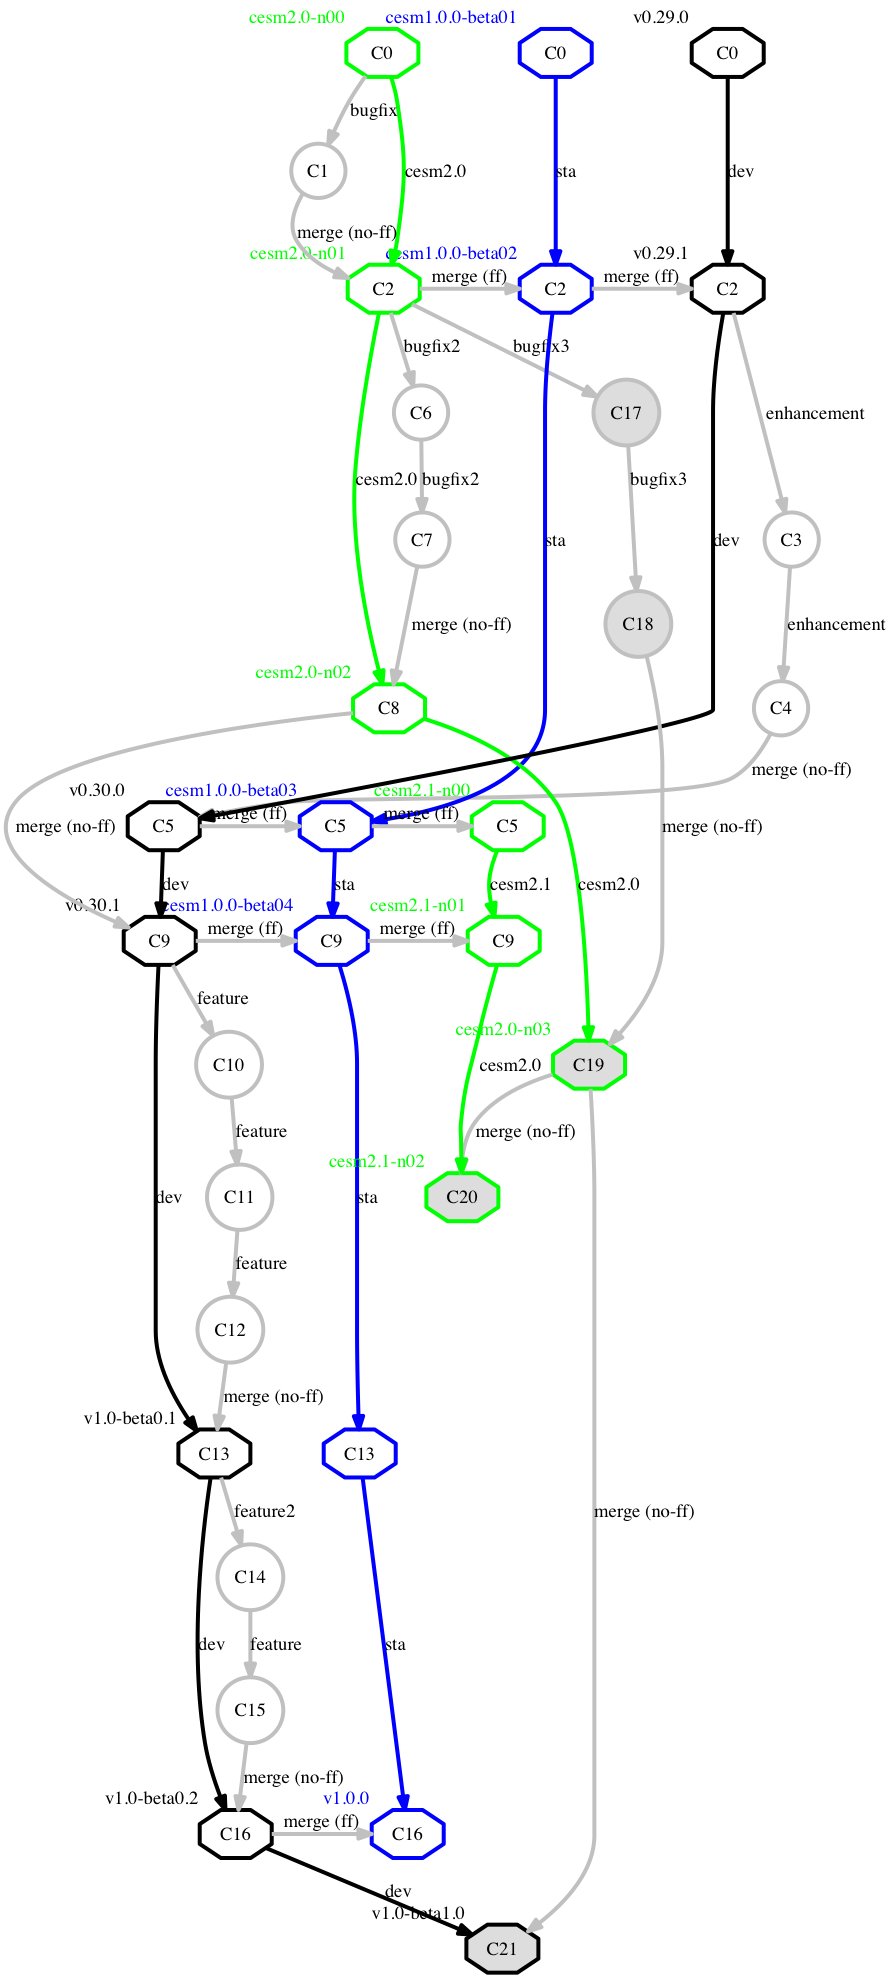

In [9]:
def stage7a(title="", node_color="white"):
    graph = stage6(title)

    # Add node for new releases
    new_node(graph, "C19", node_color, branch="release", label="cesm2.0-n03")
    new_node(graph, "C20", node_color, branch="release", label="cesm2.1-n02")
    new_node(graph, "C21", node_color, branch="development", label="v1.0-beta1.0")

    # Align C19 with C10 for readability
    subgraph = pydot.Subgraph(rank='same')
    subgraph.add_node(all_nodes["other.C10"])
    subgraph.add_node(all_nodes["release.C19"])
    graph.add_subgraph(subgraph)
    
    # Add nodes for bugfix3
    new_node(graph, "C17", node_color)
    new_node(graph, "C18", node_color)

    # Edges for feature and merge
    new_edge(graph, "release.C2", "other.C17", "bugfix3", colors["other"])
    new_edge(graph, "other.C17", "other.C18", "bugfix3", colors["other"])
    new_edge(graph, "other.C18", "release.C19", "merge (no-ff)", colors["other"])
    new_edge(graph, "release.C19", "release.C20", "merge (no-ff)", colors["other"])
    new_edge(graph, "release.C19", "development.C21", "merge (no-ff)", colors["other"])

    # Edges for development and release branches
    new_edge(graph, "release.C8", "release.C19", "cesm2.0", colors["release"])
    new_edge(graph, "release.C9", "release.C20", "cesm2.0", colors["release"])
    new_edge(graph, "development.C16", "development.C21", labels["development"], colors["development"])
    
    return graph

# Draw graph
viewPydot(stage7a(node_color=new_node_color))

### Bug introduced in "bugfix2"

Branch off of `C8` and then merge into both release branches as well as _development_

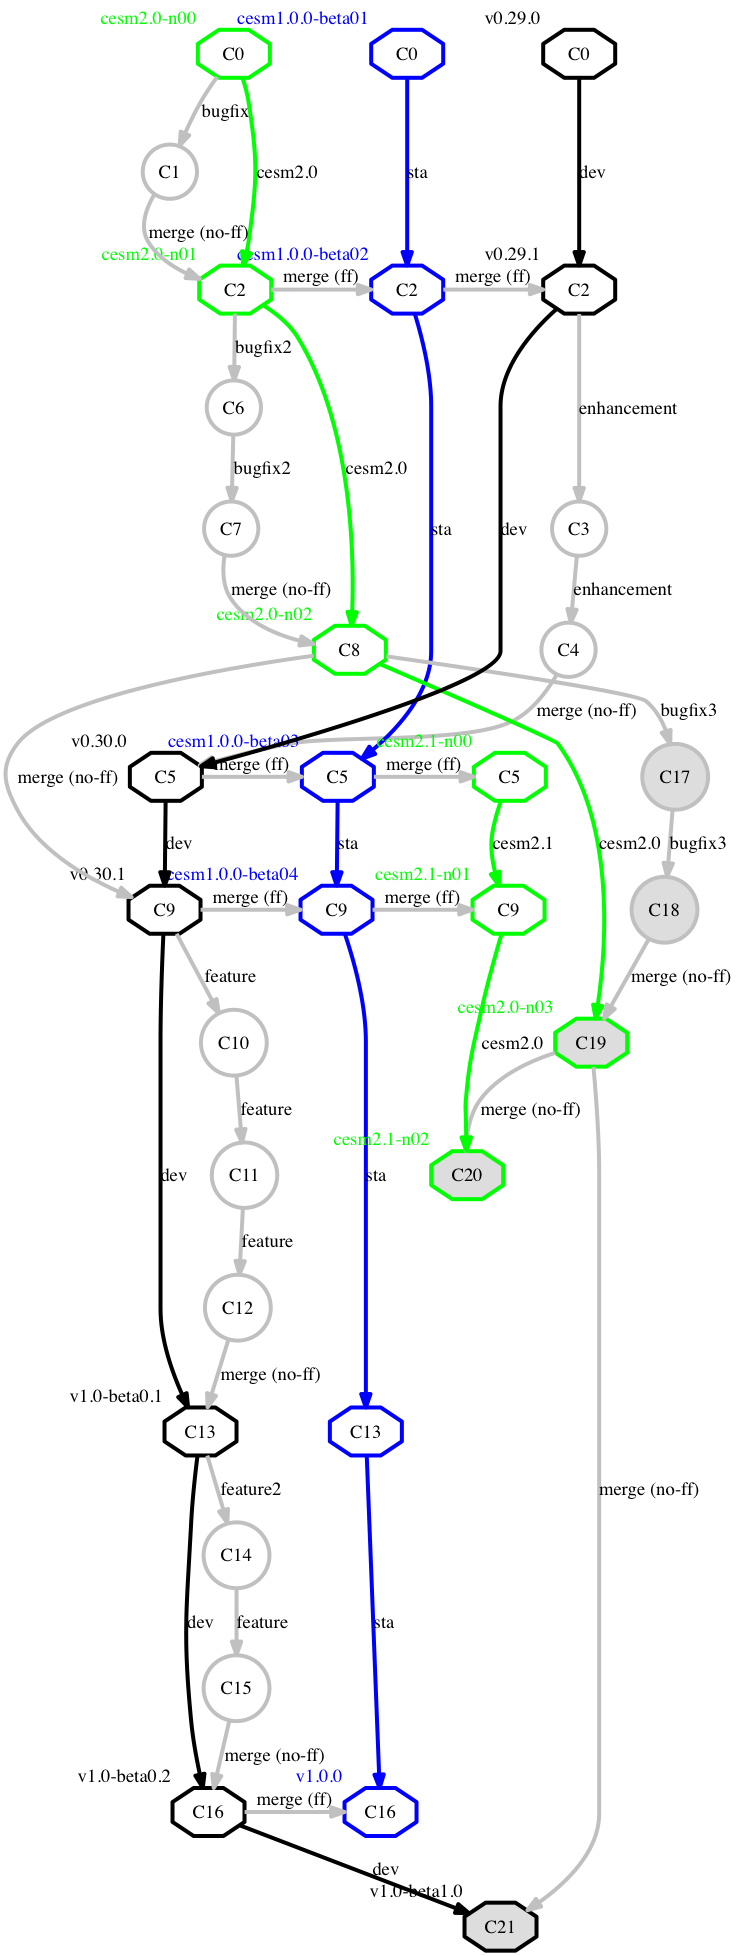

In [10]:
def stage7b(title="", node_color="white"):
    graph = stage6(title)

    # Add node for new releases
    new_node(graph, "C19", node_color, branch="release", label="cesm2.0-n03")
    new_node(graph, "C20", node_color, branch="release", label="cesm2.1-n02")
    new_node(graph, "C21", node_color, branch="development", label="v1.0-beta1.0")

    # Align C19 with C10 for readability
    subgraph = pydot.Subgraph(rank='same')
    subgraph.add_node(all_nodes["other.C10"])
    subgraph.add_node(all_nodes["release.C19"])
    graph.add_subgraph(subgraph)
    
    # Add nodes for bugfix3
    new_node(graph, "C17", node_color)
    new_node(graph, "C18", node_color)

    # Edges for feature and merge
    new_edge(graph, "release.C8", "other.C17", "bugfix3", colors["other"])
    new_edge(graph, "other.C17", "other.C18", "bugfix3", colors["other"])
    new_edge(graph, "other.C18", "release.C19", "merge (no-ff)", colors["other"])
    new_edge(graph, "release.C19", "release.C20", "merge (no-ff)", colors["other"])
    new_edge(graph, "release.C19", "development.C21", "merge (no-ff)", colors["other"])

    # Edges for development and release branches
    new_edge(graph, "release.C8", "release.C19", "cesm2.0", colors["release"])
    new_edge(graph, "release.C9", "release.C20", "cesm2.0", colors["release"])
    new_edge(graph, "development.C16", "development.C21", labels["development"], colors["development"])
    
    return graph

# Draw graph
viewPydot(stage7b(node_color=new_node_color))

In [11]:
# Source: http://blog.nextgenetics.net/?e=102
# Hide input cells?
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
(Note: the raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.)''')